In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2023-10-14 14:32:55.342895: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-14 14:32:55.503553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 14:32:56.133175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("./Data/Combined_Lebanon_Snow_Data.csv")

In [3]:
df.head()

,longitude,latitude,time,sde
0,35.65,34.5,1993-01-01 10:00:00,NaN
1,36.35,34.3,1993-01-01 10:00:00,0.067378
2,35.95,33.6,1993-01-01 10:00:00,0.007813
3,36.35,33.7,1993-01-01 10:00:00,0.004883
4,36.35,33.1,1993-01-01 10:00:00,0.000000


In [4]:
df.tail()

,longitude,latitude,time,sde
1778382,36.25,34.0,2022-12-30 10:00:00,0.002441
1778383,35.55,34.3,2022-12-30 10:00:00,NaN
1778384,36.45,33.7,2022-12-30 10:00:00,0.000000
1778385,36.05,33.8,2022-12-30 10:00:00,0.000000
1778386,36.15,34.0,2022-12-30 10:00:00,0.001953


## Data Exploration

In [5]:
df.describe()

,longitude,latitude,sde
count,1.778387e+06,1.778387e+06,1.351896e+06
mean,3.585000e+01,3.380000e+01,4.726069e-03
std,3.741658e-01,4.898981e-01,2.795796e-02
min,3.525000e+01,3.300000e+01,-2.980232e-08
25%,3.555000e+01,3.340000e+01,-7.345365e-24
50%,3.585000e+01,3.380000e+01,0.000000e+00
75%,3.615000e+01,3.420000e+01,0.000000e+00
max,3.645000e+01,3.460000e+01,6.894531e-01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778387 entries, 0 to 1778386
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   time       object 
 3   sde        float64
dtypes: float64(3), object(1)
memory usage: 54.3+ MB


In [7]:
df.isna().sum()

longitude         0
latitude          0
time              0
sde          426491
dtype: int64

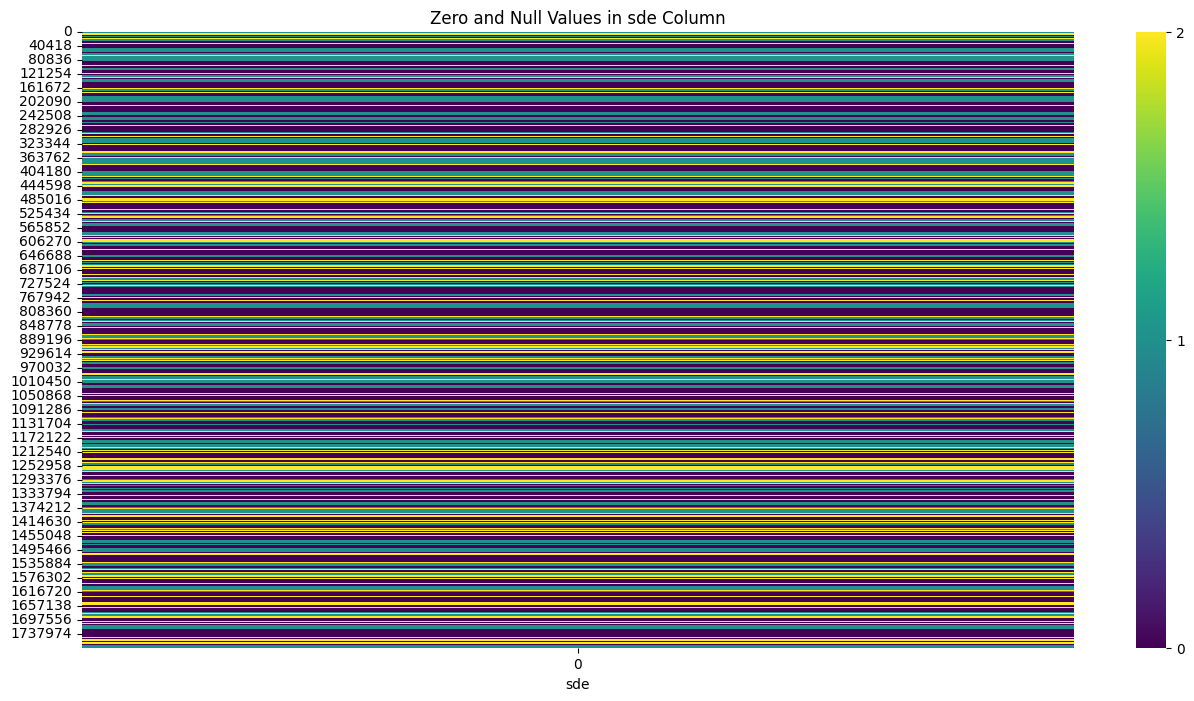

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Series with the same shape as df.sde
combined_sde = pd.Series(index=df.sde.index)

# Mark NaNs with 2
combined_sde[df.sde.isna()] = 2

# Mark zeros with 1
combined_sde[df.sde == 0] = 1

# Fill remaining spots with 0
combined_sde.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(combined_sde.values.reshape(-1, 1), cbar=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2]})
plt.title('Zero and Null Values in sde Column')
plt.xlabel('sde')
plt.show()

In [9]:
print("Percentage of null or 0 values in the sde column: {}%".format(round(((df.sde.isna().sum() + (df.sde <= 0).sum())/df.shape[0])*100, 4)))

Percentage of null or 0 values in the sde column: 89.3629%


## Data Imputation

In [10]:
from sklearn.neighbors import KDTree
import numpy as np

def drop_unnecessary_columns(df):
    """Drop unnecessary columns from the dataset."""
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    return df

In [11]:
def build_kdtree(df):
    """Build a KD-Tree using longitude and latitude from rows where 'sde' is not NaN."""
    non_na_df = df.dropna(subset=['sde'])
    return KDTree(non_na_df[['longitude', 'latitude']]), non_na_df

In [12]:
def precompute_location_means(df):
    """Pre-compute the mean 'sde' value for each unique longitude and latitude across different years."""
    means = df.groupby(['longitude', 'latitude'])['sde'].mean()
    return means.to_dict()

In [13]:
def impute_sde_optimized(row, tree, non_na_df, location_means):
    """Optimized function (Version 2) to impute missing 'sde' values."""
    if pd.isnull(row['sde']):
        # Query the KD-Tree for the indices of the 20 closest points
        dist, ind = tree.query(np.array([[row['longitude'], row['latitude']]]), k=20)
        closest_points = non_na_df.iloc[ind[0]]
        
        # Retrieve the pre-computed mean 'sde' values for these closest points
        mean_sde_values = [location_means.get((long, lat), np.nan) for long, lat in zip(closest_points['longitude'], closest_points['latitude'])]
        final_mean_sde = np.nanmean(mean_sde_values)  # Using nanmean to handle potential NaN values
        
        return max(final_mean_sde, 0)  # Ensure the value is >= 0
    else:
        return row['sde']

In [14]:
def impute_missing_values(df):
    # Drop unnecessary columns
    df = drop_unnecessary_columns(df)
    
    # Build KD-Tree
    tree, non_na_df = build_kdtree(df)
    
    # Pre-compute location means
    location_means = precompute_location_means(df)
    
    # Impute missing 'sde' values using the optimized approach
    df['sde'] = df.apply(lambda row: impute_sde_optimized(row, tree, non_na_df, location_means), axis=1)
    
    return df

In [15]:
%%time
# Impute missing values in the df and display the first few rows after imputation
df_imputed = impute_missing_values(df)

CPU times: user 1min 54s, sys: 142 ms, total: 1min 54s
Wall time: 1min 54s


In [16]:
df_imputed.head()

,longitude,latitude,time,sde
0,35.65,34.5,1993-01-01 10:00:00,0.000435
1,36.35,34.3,1993-01-01 10:00:00,0.067378
2,35.95,33.6,1993-01-01 10:00:00,0.007813
3,36.35,33.7,1993-01-01 10:00:00,0.004883
4,36.35,33.1,1993-01-01 10:00:00,0.000000


## Data Exploration Post Imputation

In [17]:
df_imputed.isna().sum()

longitude    0
latitude     0
time         0
sde          0
dtype: int64

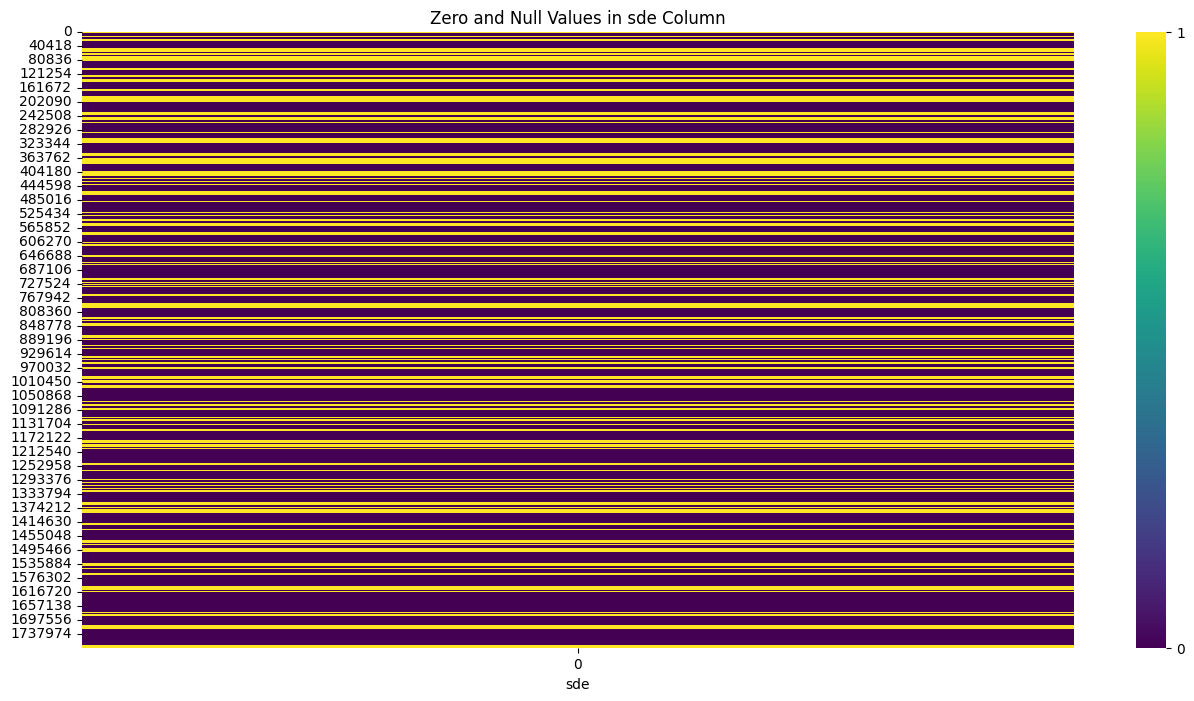

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Series with the same shape as df.sde
combined_sde = pd.Series(index=df_imputed.sde.index)

# Mark NaNs with 2
combined_sde[df_imputed.sde.isna()] = 2

# Mark zeros with 1
combined_sde[df_imputed.sde == 0] = 1

# Fill remaining spots with 0
combined_sde.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(combined_sde.values.reshape(-1, 1), cbar=True, cmap='viridis', cbar_kws={'ticks': [0, 1, 2]})
plt.title('Zero and Null Values in sde Column')
plt.xlabel('sde')
plt.show()

In [19]:
print("Percentage of null or 0 values in the sde column: {}%".format(round(((df_imputed.sde.isna().sum() + (df_imputed.sde <= 0).sum())/df.shape[0])*100, 4)))

Percentage of null or 0 values in the sde column: 65.381%


In [20]:
df.describe()

,longitude,latitude,sde
count,1.778387e+06,1.778387e+06,1.778387e+06
mean,3.585000e+01,3.380000e+01,3.743396e-03
std,3.741658e-01,4.898981e-01,2.444015e-02
min,3.525000e+01,3.300000e+01,-2.980232e-08
25%,3.555000e+01,3.340000e+01,-7.345365e-24
50%,3.585000e+01,3.380000e+01,0.000000e+00
75%,3.615000e+01,3.420000e+01,4.052500e-04
max,3.645000e+01,3.460000e+01,6.894531e-01
